<a href="https://colab.research.google.com/github/dongzooo/Quant-with-py/blob/main/1_%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4%20%EB%AA%A8%EB%8D%B8%EB%A7%81(yfinance)/4_%EC%8B%9C%EC%9E%A5_%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# yfinance 패키지 설치
!pip install yfinance --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.1 MB/s eta 0:00:00


In [ ]:
# 패키지 임포트: numpy, pandas, matplotlib, seaborn, yfinance, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

# seaborn 세팅하기
sns.set()

### ETF 가격 데이터 다운로드

In [ ]:
# 티커 리스트 정의
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

# etf 객체 정의
etf = yf.Tickers(tickers)

# ETF 시계열 가격 데이터 다운로드
data = etf.history(start='2011-01-01', actions=False)

# 종가 이외의 데이터 제거
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)

# 열 이름 레벨 다운그레이드
data = data.droplevel(0, axis=1)

[*********************100%***********************]  9 of 9 completed


In [ ]:
# 수익률 데이터
rets = data.pct_change().fillna(0)

# 기대수익률 계산
er = rets.mean() * 252

# 공분산행렬 계산
cov = rets.cov() * 252

### 샤프비율 최대화 포트폴리오

In [ ]:
# 샤프비율 최대화 포트폴리오 가중치 산출 함수 구현
def get_msr_weights(er, cov):

    # 자산개수
    noa = er.shape[0]

    # 가중치 초기값
    init_guess = np.repeat(1/noa, noa)

    # 자산 가중치 상하한
    bounds = ((0.0, 1.0), ) * noa

    # 레버리지 불가 제약조건
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol

    # 최적화 수행
    res = sco.minimize(neg_sharpe,
                       init_guess,
                       args=(er, cov),
                       method='SLSQP',
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    
    return res.x

In [ ]:
# MSR 포트폴리오 가중치
msr_weights = get_msr_weights(er, cov)

# MSR 포트폴리오 수익률
msr_ret = np.dot(msr_weights, er)

# MSR 포트폴리오 변동성
msr_vol = np.sqrt(np.dot(msr_weights.T, np.dot(cov, msr_weights)))

print('Return = {}'.format(msr_ret))
print('Volatility = {}'.format(msr_vol))

Return = 0.1477094615575011
Volatility = 0.158067328537797


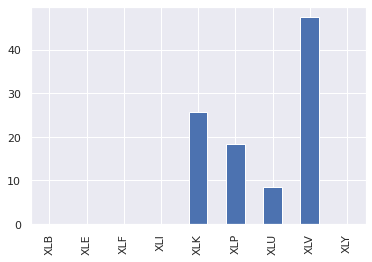

In [ ]:
# 시장 포트폴리오 가중치 시각화
msr_weights_series = pd.Series(np.round(msr_weights, 4) * 100, index=tickers)
msr_weights_series.plot.bar()

In [ ]:
# 시장 포트폴리오 수익률과 변동성


### 자본시장선 구현

In [ ]:
# 포트폴리오 통계치 계산 함수
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(er * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return np.array([pret, pvol, pret/pvol])

# 목적함수 정의
def obj_func(weights):
    return statistics(weights)[1]

In [ ]:
# 자산의 개수
noa = len(tickers)

# 수익률 수준별 포트폴리오 최적화 수행
trets = np.linspace(0.1, 0.15, 50)
tvols = []

for tret in trets:

    # 가중치 초기값
    init_guess = np.repeat(1/noa, noa)

    # 제약조건
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # 자산 가중치 상하한
    bnds = ((0.0, 1.0), ) * noa

    # 최적화 수행
    res = sco.minimize(obj_func,
                       init_guess,
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)

    tvols.append(res['fun'])

tvols = np.array(tvols)

In [ ]:
# 좌측 경계선 데이터 수집
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [ ]:
evols[-1]

0.16058492008182595

Text(0.5, 1.0, 'Market Portfolio & Capital Market Line')

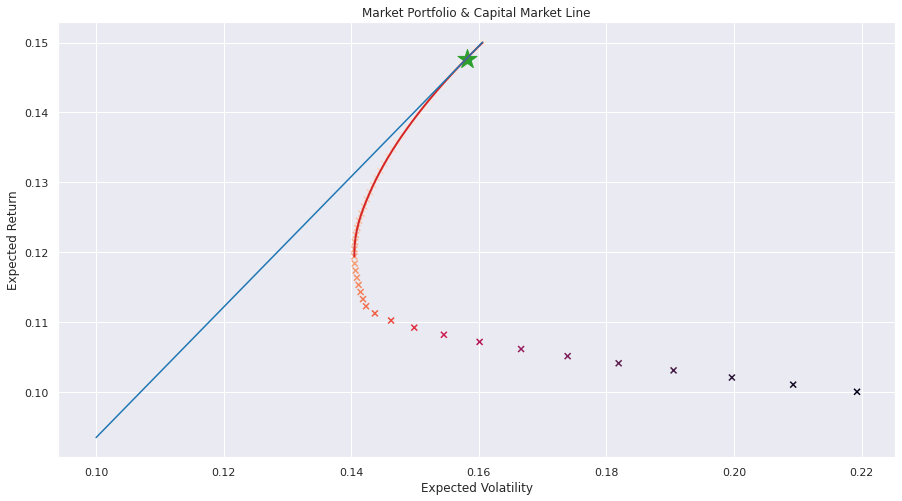

In [ ]:
# 자본시장선 데이터
x = np.linspace(0.1, evols[-1], 100)
y = (msr_ret / msr_vol) * x

# 효율적 경계선 및 자본시장선 시각화
plt.figure(figsize=(15, 8))

plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.plot(evols, erets, 'tab:red', lw=2.0)

# 시장 포트폴리오
plt.scatter(msr_vol, msr_ret, marker='*', s=400, color='tab:green')

# 자본시장선
plt.plot(x, y, 'tab:blue')

plt.grid(True)

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

plt.title('Market Portfolio & Capital Market Line')
